# Classificació de senyals de trànsit amb LeNet-5 
by **Bruna da Silva**

---
## Pas 0: Importa les llibreries i les dades
Importem algunes de les llibreries que necessitem per aquest projecte.

In [2]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

Prenem les dades, és a dir, les imatges que hem descarregat i que es troben a la carpeta 'training'. Emmagatzemarem les imatges en una llista ("images") i les seves etiquetes corresponents en una altra ("labels"). 

In [3]:
images = [] 
labels = [] 
classes = 43 # Tenim 43 categories per classificar les imatges

current_path = 'training/'

for i in range(classes):
    path = os.path.join(current_path, str(str(i).zfill(5))) # Construim les rutes de les carpetes de cada classe
    img_folder = os.listdir(path)
    for j in img_folder:
        try:
            image = cv.imread(str(path+'/'+j))
            image = cv.resize(image, (32, 32))              # Redimensionem les imatges a 32x32 px
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)    # Convertim la imatge del format BGR (el format per defecte d'OpenCV) a RGB.
            image = np.array(image)     # Convertim la imatge en un array de NumPy, per facilitar la manipulació de dades.
            images.append(image)        # Afegim la imatge a la llista
            label = np.zeros(classes)   # Creem l'etiqueta per la classe
            label[i] = 1.0
            labels.append(label)        # Afegim l'etiqueta a la llista
        except:
            pass

images = np.array(images)
labels = np.array(labels) # Convertim les llistes en un array de NumPy, per poder utilitzar-lo fàcilment en un model de machine learning.

---
## Pas 1: Exploració i resum de les dades

### 1. Divisió de les dades
Del dataset sencer, un 75% de les dades seran d'entrenament, un 15% de validació, i un 10% de test. 

Primer convertirem l'array "images" a un tipus de dades int16 (números enters de 16 bits) i el "labels" a un float32 (números en coma flotant de 32 bits). Això pot ser útil per optimitzar l'ús de memòria o per ajustar el tipus de dades als requisits del model.

In [4]:
X = images.astype(np.int16)     
y = labels.astype(np.float32)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=123) # Dividim les dades en dos conjunts: un d'entrenament i un altre de prova 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=123) # Dividim el conjunt de prova en un de validació i un altre de prova definitiu

# Imprimim la forma dels diferents conjunts de dades (nombre d'imatges, alçada, amplada, canals de color)
# Imprimim la forma dels diferents conjunts d'etiquetes (nombre d'etiquetes, nombre de classes)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (19980, 32, 32, 3)
y_train shape: (19980, 43)
X_valid shape: (3996, 32, 32, 3)
y_valid shape: (3996, 43)
X_test shape: (2664, 32, 32, 3)
y_test shape: (2664, 43)


### 2. Resum bàsic del dataset
Obtenim informació del dataset.

In [5]:
# Nombre d'exemples d'entrenament
n_train = X_train.shape[0]

# Nombre d'exemples de validació
n_validation = X_valid.shape[0]

# Nombre d'exemples de prova
n_test = X_test.shape[0]

# La mida de les imatges
image_shape = X_train.shape[1:4]

# Quantes classes úniques, o etiquetes, hi ha
n_classes = np.unique(ar=y_train).shape[0]

# La profunditat de color de les imatges (el nombre de canals)
image_depth_dimension = X_train.shape[3]

print("Nombre d'exemples d'entrenament =", n_train)
print("Nombre d'exemples de prova =", n_test)
print("Mida de les imatges =", image_shape)
print("Nombre de classes =", n_classes)

Nombre d'exemples d'entrenament = 19980
Nombre d'exemples de prova = 2664
Mida de les imatges = (32, 32, 3)
Nombre de classes = 2


Les imatges són de 32x32x3, és a dir, imatges en color d'una resolució molt baixa. A partir d'algunes escollides a l'atzar podem observar com són les imatges del dataset.

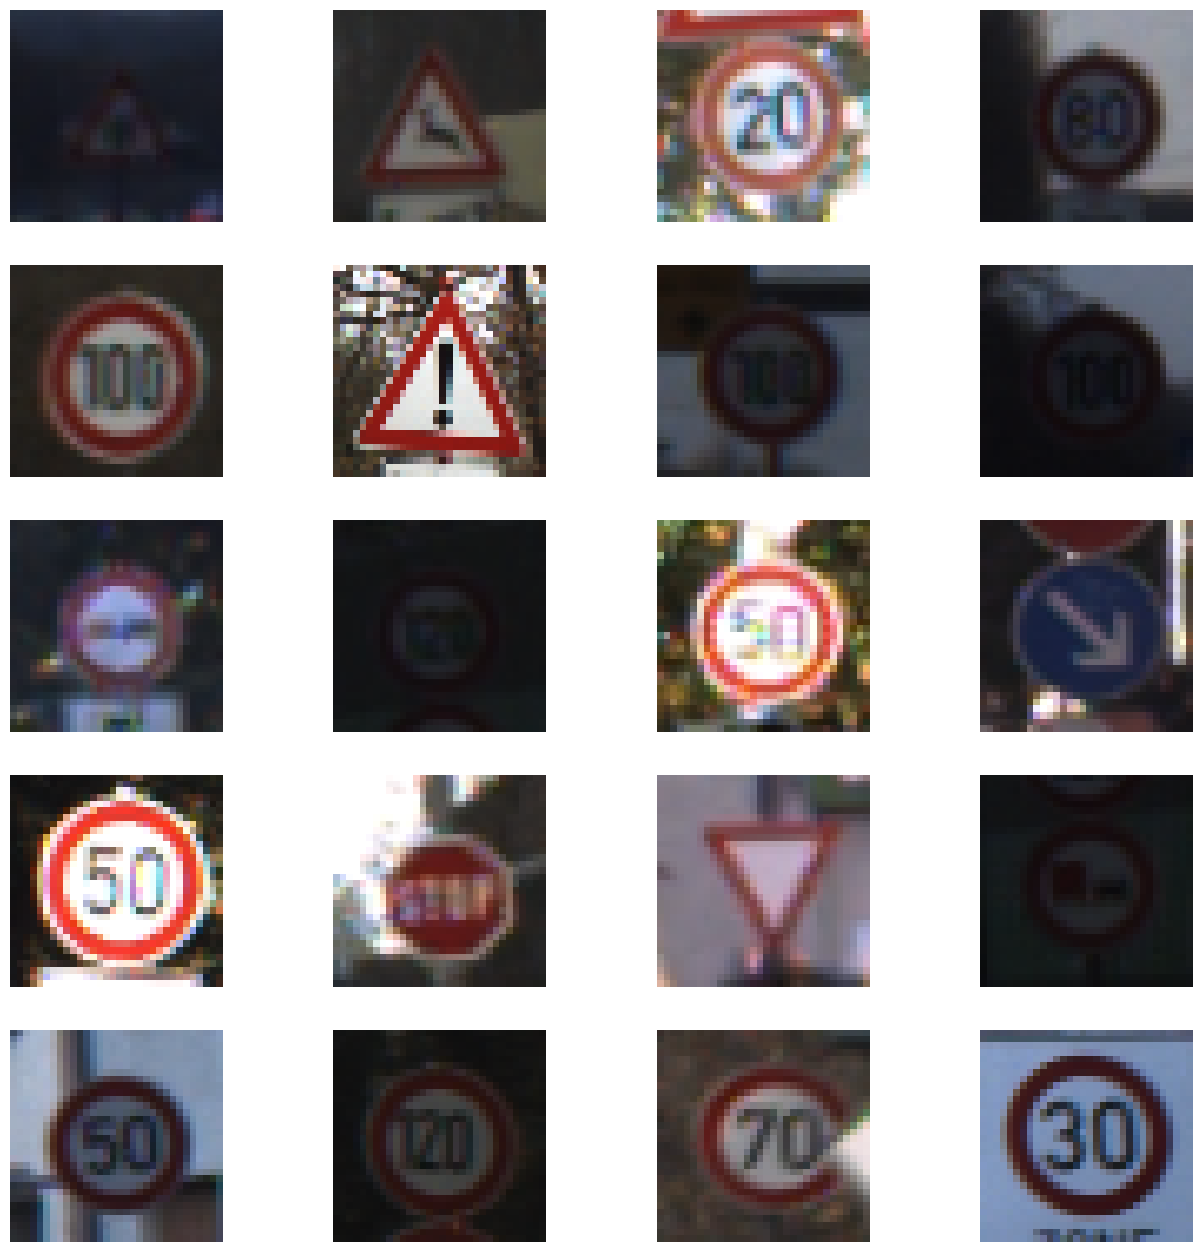

In [6]:
import matplotlib.pyplot as plt
from random import randint

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5    # Mostrarem 20 imatges a l'atzar en una graella

for i in range(1, columns*rows +1):
    # Mostrem imatges del dataset a l'atzar 
    img = X_train[randint(0, n_train-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')   
plt.show()

---
## Pas 2: Preprocessament de les imatges

### 1. Normalització

In [7]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [length, width, color_depth]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

# Creem uns arrays per cada conjunt de dades on emmagatzemar les imatges normalitzades:
normalized_train = np.zeros([n_train,32,32,3])
normalized_validation = np.zeros([n_validation,32,32,3])
normalized_test = np.zeros([n_test,32,32,3])

# Comprovem que les dimensions de les dades normalitzades són les mateixes que les originals:
for i in range(0,n_train):
    normalized_train[i] = normalize(X_train[i])
for i in range(0,n_validation):
    normalized_validation[i] = normalize(X_valid[i])
for i in range(0,n_test):
    normalized_test[i] = normalize(X_test[i])

assert(X_train.shape==normalized_train.shape)

### 2. Mostrem la diferència que marca la normalització

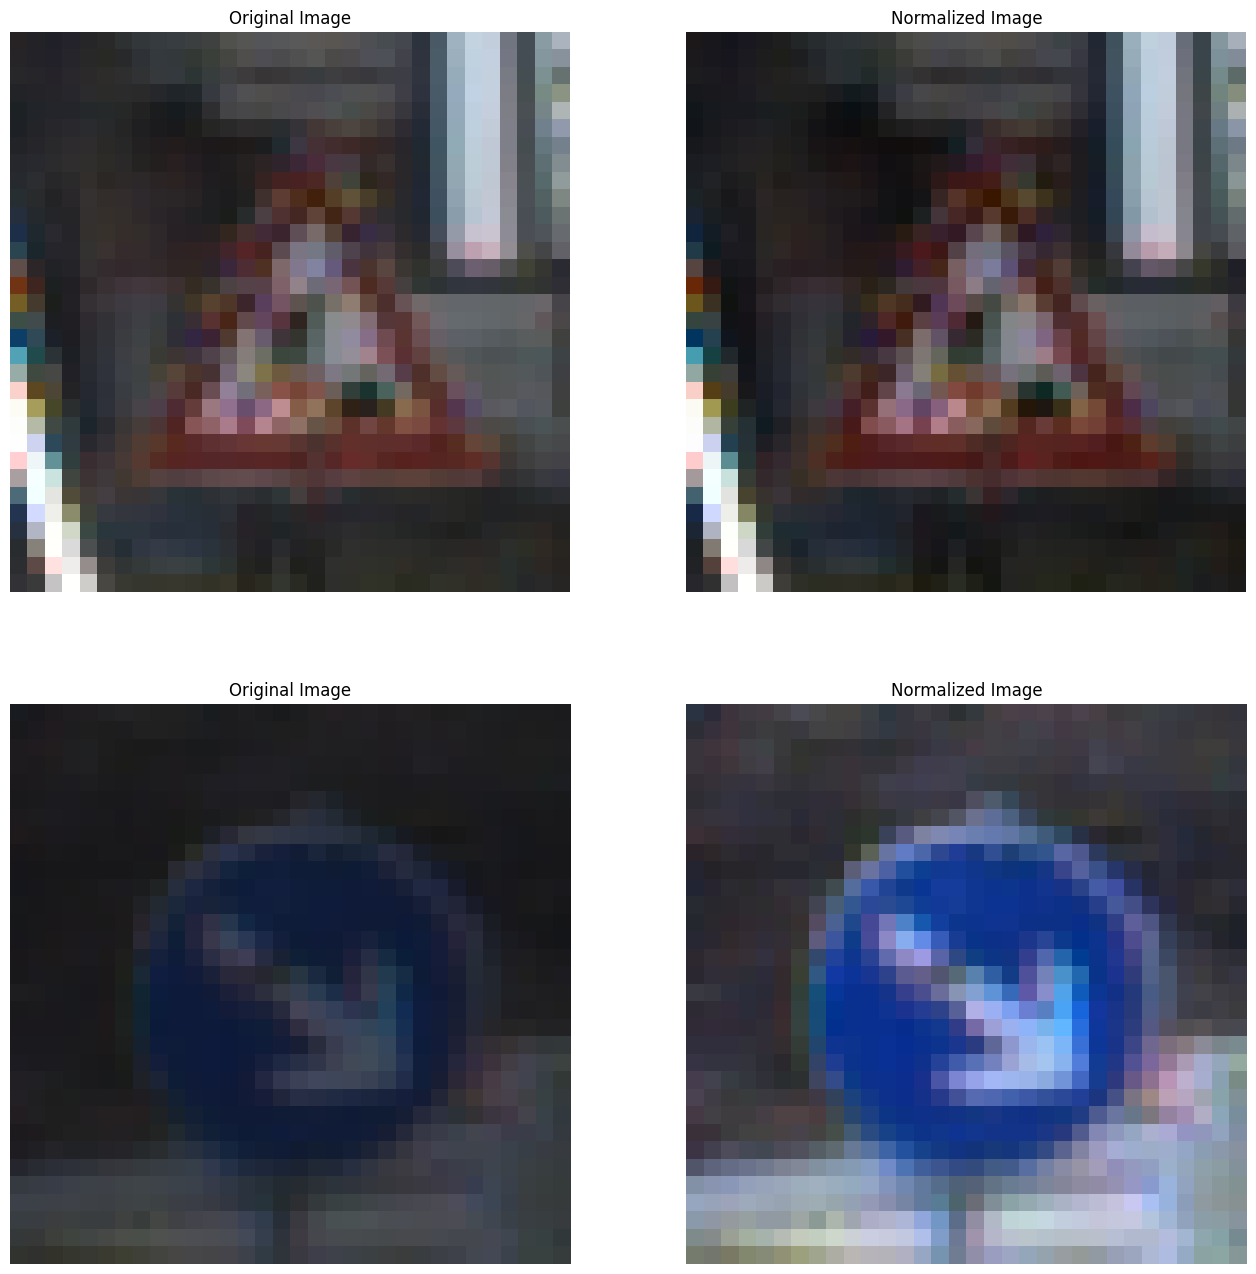

In [8]:
f, axarr = plt.subplots(nrows=2,ncols=2,figsize = (16,16)) # Mostrarem 2 imatges a l'atzar junt amb la seva normalització en una graella
randomindex = randint(0,n_train-1)
axarr[0,0].imshow(X_train[randomindex])
axarr[0,0].axis('off')
axarr[0,0].set_title('Original Image')
axarr[0,1].imshow(normalized_train[randomindex])
axarr[0,1].axis('off')
axarr[0,1].set_title('Normalized Image')
randomindex = randint(0,n_train-1)
axarr[1,0].imshow(X_train[randomindex])
axarr[1,0].axis('off')
axarr[1,0].set_title('Original Image')
axarr[1,1].imshow(normalized_train[randomindex])
axarr[1,1].axis('off')
axarr[1,1].set_title('Normalized Image')

plt.show()

### 3. Fem que les imatges normalitzades siguin les que es facin servir 

Substituim els diferents conjunts d'imatges no preprocessades pels nous conjunts d'imatges normalitzades per utilitzar-les dins el nostre model.

In [9]:
X_train = normalized_train

X_valid = normalized_validation

X_test = normalized_test

---
## Pas 3: Construim el model

Creem un **model seqüencial** que conté les capes afegides dins dels claudàtors [ ... ]. Cada capa s'aplica en l'ordre en què es defineix. Afegirem els tipus de capes següents:
- **Rescaling**: Reescala els valors de píxels de les imatges d'entrada. Aquí, "Rescaling(1, ...) no canvia els valors.

- **Conv2D**: Afegeix una [capa convolucional](https://www.ibm.com/topics/convolutional-neural-networks) amb X filtres de mida 5x5. Aquesta capa detecta característiques bàsiques a les imatges, com vores i textures.

- **AveragePooling2D**: Aplica un [pool mitjà](https://www.ibm.com/topics/convolutional-neural-networks) amb una finestra de 2x2 píxels , reduint la mida espacial de l'entrada.

- **Dropout**: Afegeix una capa de Dropout que desactiva aleatòriament el 20% de les neurones durant l'entrenament per evitar el [sobreajustament  o overfitting](https://www.ibm.com/es-es/topics/overfitting).

- **Flatten**: Aplana la sortida de les capes anteriors en un vector unidimensional, preparant-lo per a la capa totalment connectada (fully connected, FC)).

- **Dense**(units=120, activation='relu'): Afegeix una capa FC amb 120 neurones.

- **Dense**(units=43, activation='softmax'): Afegeix la capa de sortida amb 43 neurones, que correspon al nombre de classes. La funció d'activació softmax converteix les sortides en probabilitats.

In [10]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

model = Sequential([    

    Rescaling(1, input_shape=(32, 32, 3)),  
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilació del model:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrem un resum de l'arquitectura del model:
model.summary()

2024-09-05 19:56:24.289344: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 19:56:24.434741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 19:56:24.593347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 19:56:24.732746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 19:56:24.776253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 19:56:25.002745: I tensorflow/core/platform/cpu_feature_gu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,715 (276.23 KB)

 Trainable params: 70,715 (276.23 KB)

 Non-trainable params: 0 (0.00 B)

---
## Pas 4: Entrenem el model

In [11]:
# L'entrenem
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

# Guardem el model a la carpeta "model"
model.save('./model/lenet.keras')


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3509 - loss: 2.4180 - val_accuracy: 0.8468 - val_loss: 0.5120
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8167 - loss: 0.5907 - val_accuracy: 0.9174 - val_loss: 0.3009
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8868 - loss: 0.3579 - val_accuracy: 0.9449 - val_loss: 0.2178
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9190 - loss: 0.2590 - val_accuracy: 0.9459 - val_loss: 0.1986
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9357 - loss: 0.2053 - val_accuracy: 0.9657 - val_loss: 0.1414
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9484 - loss: 0.1648 - val_accuracy: 0.9752 - val_loss: 0.1146
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9642 - loss: 0.1238 - val_accuracy: 0.9732 - val_loss: 0.1173
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9642 - loss: 0.1159 - val_accuracy: 0.

---
## Pas 5: Avaluem

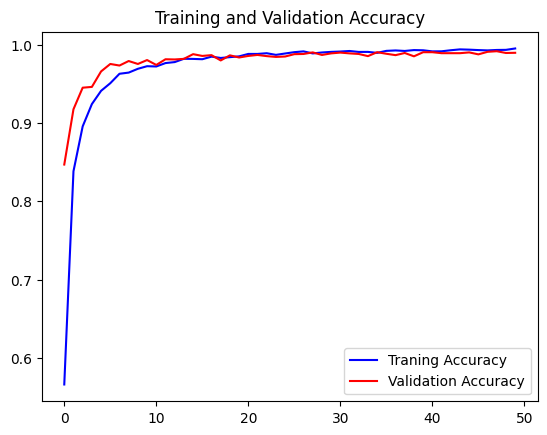

In [20]:
train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

epochs = range(len(train_accuracy))
plt.plot(epochs, train_accuracy, 'b', label='Traning Accuracy')
plt.plot(epochs, valid_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

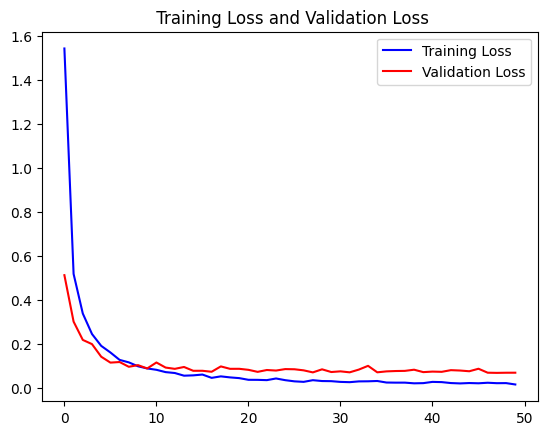

In [21]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.title(' Training Loss and Validation Loss')
plt.legend()

In [13]:
# Guardem el model a la carpeta "model"
model.save('./model/lenet.keras')

---
## Pas 6: Provem el model en imatges noves

Per comprovar si realment tenim un model funcional, prenem unes imatges completament noves que es troben a la carpeta [mysigns](mysigns) i les passem pel model, que ens ha de dir quina classe de senyal de trànsit contenen.

In [14]:
import pandas as pd

# Per fer-ho més visual, prendrem com a etiquetes la llista de noms que es troba en el fitxer "noms_senyals.csv"
input = pd.read_csv("Noms_senyals.csv")
class_names = input.nom

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


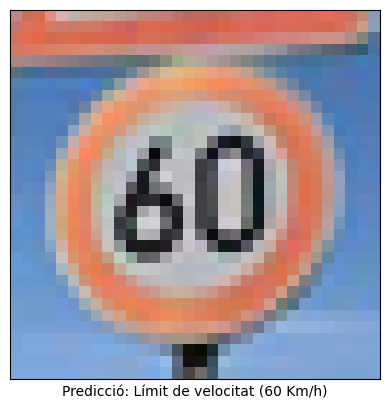

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


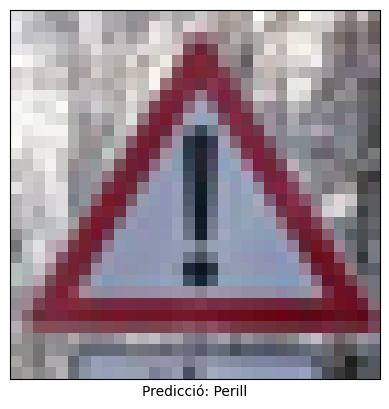

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


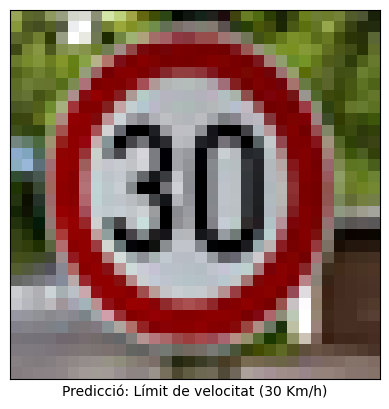

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


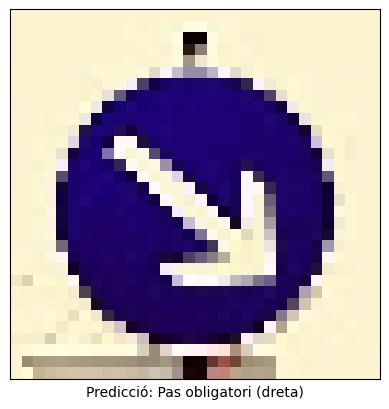

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


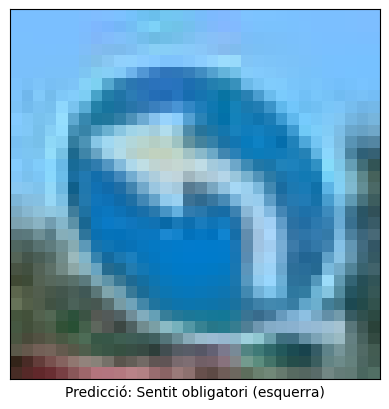

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


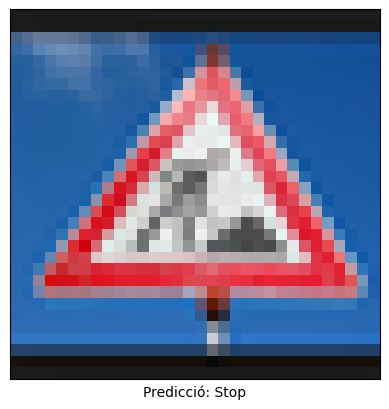

In [15]:
model = load_model('./model/lenet.keras') # Carreguem el model

my_images_path = './mysigns/'
my_images_folder = os.listdir(my_images_path)

for file_name in my_images_folder:
    img = cv.imread(my_images_path + file_name)
    img = cv.resize(img, (32, 32))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.array(img)

    img = img.astype(np.int16)
    img = normalize(img) # Normalitzem aquestes imatges noves

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    img = img.reshape(1, 32, 32, 3)
    pred = model.predict(img)   # El model fa les prediccions
    pred_class = np.argmax(pred)
    pred_label = class_names[pred_class]

    plt.xlabel('Predicció: ' + pred_label)
    plt.show() # Mostrem els resultats